In [1]:
import sys
sys.path.append("..")
from utilities import *

warnings.filterwarnings("ignore")

raw_data = pd.read_excel("../data/Datos_Market_copy.xlsx")

sa = SalesAnalysis(raw_data)

/Users/oscarjimenezbou/Documents/TFG_ADE/code_prophet/TFG/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
%run 1_preprocessing_data.ipynb

In [3]:
(
    data,
    filter_data, 
    train_data,
    test_data,
    y_train_boxcox,
    y_test_boxcox,
    boxcox_transformation_info,
) = run_preprocessing(ARIMA_model=False)

data = data[
    data["brand"].isin(["brand-35", "brand-14", "brand-15"])
] # Filtramos las 3 brands principales únicamente


PROPHET

In [4]:
# ============================================================================
# PASO 1: Preparación de datos y creación de series_id
# ============================================================================

# Convertir date a datetime si no lo está
data['date'] = pd.to_datetime(data['date'])

# Crear series_id combinando brand + supermarket + variant + pack_size
data['series_id'] = (
    data['brand'].astype(str) + '_' + 
    data['supermarket'].astype(str) + '_' + 
    data['variant'].astype(str) + '_' + 
    data['pack.size'].astype(str)
)

# Ordenar por series_id y date
data = data.sort_values(['series_id', 'date']).reset_index(drop=True)

print(f"Número de series únicas: {data['series_id'].nunique()}")
print(f"Series ID ejemplo: {data['series_id'].iloc[0]}")
print(f"Rango de fechas: {data['date'].min()} a {data['date'].max()}")

Número de series únicas: 113
Series ID ejemplo: brand-14_supermarket-A_flavoured_0 - 350 GR
Rango de fechas: 2021-01-31 00:00:00 a 2023-12-31 00:00:00


In [5]:
# ============================================================================
# PASO 2: Split temporal
# ============================================================================

# Fijar fechas explícitamente (igual que CatBoost)
# Split basado en fecha, no en índice de filas

train_cutoff = pd.Timestamp('2023-06-30')
test_start = pd.Timestamp('2023-07-01')
test_end = pd.Timestamp('2023-12-31')

train_data = data[data['date'] <= train_cutoff].copy()
test_data = data[(data['date'] >= test_start) & (data['date'] <= test_end)].copy()

print(f"Train: {len(train_data)} filas, desde {train_data['date'].min()} hasta {train_data['date'].max()}")
print(f"Test: {len(test_data)} filas, desde {test_data['date'].min()} hasta {test_data['date'].max()}")
print(f"Número de series en train: {train_data['series_id'].nunique()}")
print(f"Número de series en test: {test_data['series_id'].nunique()}")

#FIXME: predecir solo las series que tengan datos en test

Train: 2814 filas, desde 2021-01-31 00:00:00 hasta 2023-06-30 00:00:00
Test: 589 filas, desde 2023-07-31 00:00:00 hasta 2023-12-31 00:00:00
Número de series en train: 113
Número de series en test: 107


In [6]:
# ============================================================================
# PASO 3: Quedarnos solo con las series que tienen datos en test
# ============================================================================

# Nos quedamos solo con las series que tienen datos en test
series_with_data_in_test = test_data['series_id'].unique()
train_data = train_data[train_data['series_id'].isin(series_with_data_in_test)]

print(f"Series evaluadas (presentes en test): {len(series_with_data_in_test)}")
print(f"Train tras filtrar: {train_data['series_id'].nunique()} series")
print(f"Test tras filtrar: {test_data['series_id'].nunique()} series")


Series evaluadas (presentes en test): 107
Train tras filtrar: 107 series
Test tras filtrar: 107 series


### Miramos series en grafico

Filtrado por marca: brand-14
Filtrado por supermercado: supermarket-A
Filtrado por variante: vegan

Total de series a plotear: 2
Gráfico 1/2 completado: brand-14_supermarket-A_vegan_351 - 500 GR


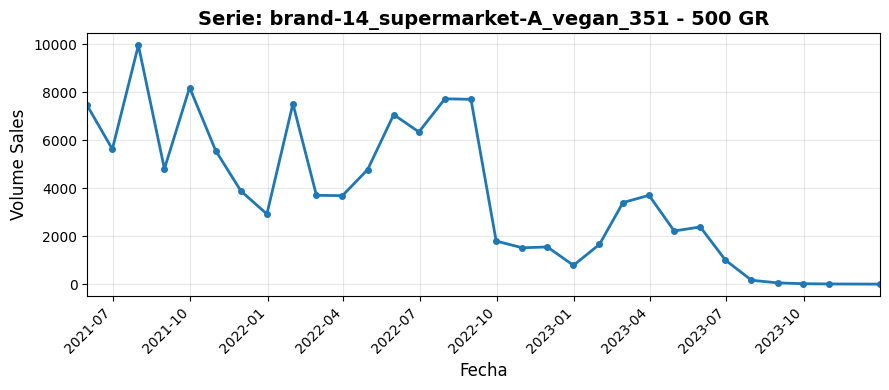

Gráfico 2/2 completado: brand-14_supermarket-A_vegan_701 - 1000 GR


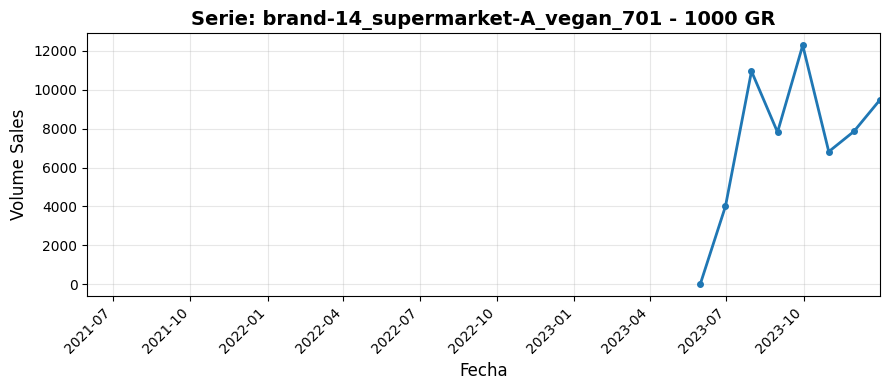


✅ Se han generado 2 gráficos individuales


In [7]:
from new_models.plot_every_series import plot_every_series

_brand = "brand-14"
_supermarket = "supermarket-A"
_variant = "vegan"
_pack_size = "351 - 500 GR"

plot_every_series(
    data, 
    filter_brand=_brand, 
    filter_supermarket=_supermarket, 
    filter_variant=_variant, 
    # filter_pack_size=_pack_size
)
# plot_every_series(
#     data, 
#     filter_brand='brand-15', 
#     filter_supermarket='supermarket-C', 
#     filter_variant='light', 
#     filter_pack_size='501 - 700 GR'
# )

In [8]:
# ============================================================================
# PASO 4: Entrenar Prophet
# ============================================================================

def prepare_data_prophet(df_one_series):

    df = df_one_series.sort_values('date').copy()

   # Agregar por mes por si hubiera duplicados (seguridad)
    agg_dict = {"volume.sales": "sum"}
    for r in ["price"]:
        agg_dict[r] = "mean"  # o "last" si el precio es del final de mes

    df = df.groupby("date", as_index=False).agg(agg_dict)
    
    df = df.set_index("date").asfreq("M")
    # Opciones para missing:
    # - target: si falta un mes, puede ser 0 ventas o missing real. Ajusta según negocio.
    # Aquí: dejamos NaN y luego lo tratamos (Prophet no acepta y NaN en train).

    # Reindex mensual (Month Start). Si tu date ya es fin de mes, ajusta a "M".

    for r in ["price"]:
        if r in df.columns:
            df[r] = df[r].ffill()

    df = df.reset_index().rename(columns={"date": "ds", "volume.sales": "y"})

    return df


In [9]:
# serie_example = test_data["series_id"].iloc[40]
brand_example = "brand-15"
supermarket_example = "supermarket-D"
variant_example = "light"
pack_size_example = "0 - 350 GR"

serie_example = f"{brand_example}_{supermarket_example}_{variant_example}_{pack_size_example}"
# serie_example = "brand-35_supermarket-A_vegan_0 - 350 GR"
print(serie_example)

train_series = train_data[train_data["series_id"] == serie_example]
data_series = data[data["series_id"] == serie_example]

brand-15_supermarket-D_light_0 - 350 GR


Filtrado por marca: brand-15
Filtrado por supermercado: supermarket-D
Filtrado por variante: light
Filtrado por tamaño: 0 - 350 GR

Total de series a plotear: 1
Gráfico 1/1 completado: brand-15_supermarket-D_light_0 - 350 GR


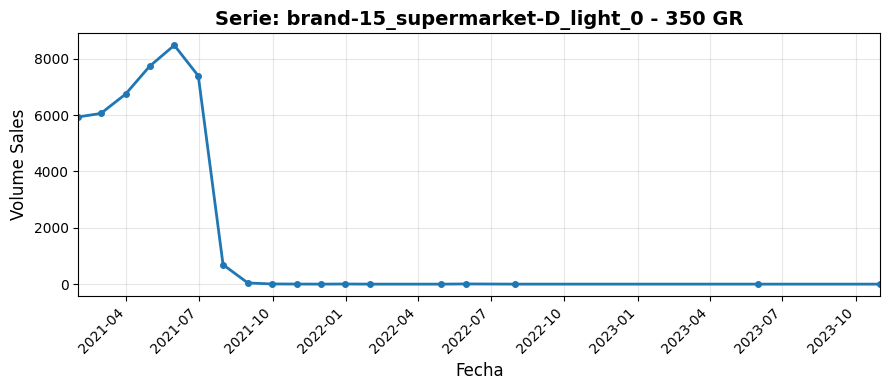


✅ Se han generado 1 gráficos individuales


18:53:07 - cmdstanpy - INFO - Chain [1] start processing
18:53:09 - cmdstanpy - INFO - Chain [1] done processing


          ds     y         yhat   yhat_lower   yhat_upper
0 2023-10-31  0.25  6923.803691  6922.653813  6924.825357
MAE: 6923.553690856781
MAPE (%): 2769421.4763427125
RMSE: 6923.553690856781


In [10]:
# ----------------------------------------------------------------------------
from new_models.plot_every_series import plot_every_series

plot_every_series(
    data_series,
    filter_brand=brand_example,
    filter_supermarket=supermarket_example,
    filter_variant=variant_example,
    filter_pack_size=pack_size_example,
)

# ----------------------------------------------------------------------------

train_series = train_data[train_data["series_id"] == serie_example]
test_series = test_data[test_data["series_id"] == serie_example]

df_train = prepare_data_prophet(train_series)
df_test = prepare_data_prophet(test_series)

df_train = df_train.dropna(subset=["y"]).copy()

# Validar que hay suficientes datos para Prophet (mínimo 2 filas no-NaN)
if len(df_train) < 2:
    raise ValueError(f"Datos insuficientes para entrenar Prophet. Solo hay {len(df_train)} filas válidas después de eliminar NaN. Se requieren al menos 2 filas.")

# Crear modelo Prophet
model = Prophet(
    # yearly_seasonality=20,
    yearly_seasonality=True,
    # yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode="multiplicative", #TODO: funciona con tranformación de logaritmo, el additivo no funciona con esto
    # seasonality_mode="additive",
    # changepoint_prior_scale=0.05,
    # changepoint_range=0.5,
    # seasonality_prior_scale=1,
    # interval_width=0.80,
    # changepoints=None,
    # mcmc_samples=0,
)

# price_mean = df_train["price"].mean()
# price_std = df_train["price"].std()
# df_train["price_normalized"] = (df_train["price"] - price_mean) / price_std
# df_test["price_normalized"] = (df_test["price"] - price_mean) / price_std

# model.add_regressor("price_normalized")
model.add_regressor("price")

# df_train["y"] = np.log1p(df_train["y"])

model.fit(df_train)

# Para predecir, el dataframe debe tener ds + regresores (si los usaste)
future = df_test[["ds"] + ["price"]].copy()
# future = df_test[["ds"] + ["price_normalized"]].copy()

forecast = model.predict(future)

# # Aplicar la transformación inversa a las predicciones
# forecast["yhat"] = np.expm1(forecast["yhat"])
# forecast["yhat_lower"] = np.expm1(forecast["yhat_lower"])
# forecast["yhat_upper"] = np.expm1(forecast["yhat_upper"])

# Unir con real para comparar
pred_df = df_test[["ds", "y"]].merge(
    forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]], on="ds", how="left"
)

print(pred_df.head(12))


def mae(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    return np.mean(np.abs(y_true[mask] - y_pred[mask]))


def rmse(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    return np.sqrt(np.mean((y_true[mask] - y_pred[mask]) ** 2))

def mape(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred) & (y_true != 0)
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

print("MAE:", mae(pred_df["y"], pred_df["yhat"]))
print("MAPE (%):", mape(pred_df["y"], pred_df["yhat"]))
print("RMSE:", rmse(pred_df["y"], pred_df["yhat"]))

# # Evaluar en escala log (más justo)
# # forecast no tiene columna 'y', así que usamos los reales de test transformados a log
# mae_log = mae(np.log1p(df_test["y"]), np.log1p(forecast["yhat"]))
# print(f"MAE en escala log: {mae_log}")

In [11]:
# # ============================================================================
# # PASO 5: Entrenar Prophet para TODAS las series y calcular métricas
# # ============================================================================

# def mae(y_true, y_pred):
#     y_true = np.asarray(y_true)
#     y_pred = np.asarray(y_pred)
#     mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
#     if mask.sum() == 0:
#         return np.nan
#     return np.mean(np.abs(y_true[mask] - y_pred[mask]))


# def rmse(y_true, y_pred):
#     y_true = np.asarray(y_true)
#     y_pred = np.asarray(y_pred)
#     mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
#     if mask.sum() == 0:
#         return np.nan
#     return np.sqrt(np.mean((y_true[mask] - y_pred[mask]) ** 2))


# def mape(y_true, y_pred):
#     y_true = np.asarray(y_true)
#     y_pred = np.asarray(y_pred)
#     mask = ~np.isnan(y_true) & ~np.isnan(y_pred) & (y_true != 0)
#     if mask.sum() == 0:
#         return np.nan
#     return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100


# # Almacenar resultados
# results = []
# all_predictions = []

# # Obtener todas las series únicas
# all_series = sorted(series_with_data_in_test)

# print(f"Entrenando Prophet para {len(all_series)} series...")
# print("=" * 80)

# for idx, serie_id in enumerate(all_series, 1):
#     try:
#         # Obtener datos de train y test para esta serie
#         train_series = train_data[train_data["series_id"] == serie_id].copy()
#         test_series = test_data[test_data["series_id"] == serie_id].copy()
        
#         if len(train_series) == 0 or len(test_series) == 0:
#             print(f"[{idx}/{len(all_series)}] {serie_id}: Sin datos suficientes, saltando...")
#             continue
        
#         # Preparar datos para Prophet
#         df_train = prepare_data_prophet(train_series)
#         df_test = prepare_data_prophet(test_series)
        
#         # Eliminar NaN en y para entrenamiento
#         df_train = df_train.dropna(subset=["y"]).copy()
        
#         if len(df_train) < 3:  # Mínimo de datos para Prophet
#             print(f"[{idx}/{len(all_series)}] {serie_id}: Datos insuficientes para entrenar (< 3 puntos), saltando...")
#             continue
        
#         # Normalizar precio
#         price_mean = df_train["price"].mean()
#         price_std = df_train["price"].std()
        
#         if price_std == 0 or np.isnan(price_std):
#             # Si no hay variación en precio, no usar como regresor
#             df_train["price_normalized"] = 0
#             df_test["price_normalized"] = 0
#             use_price_regressor = False
#         else:
#             df_train["price_normalized"] = (df_train["price"] - price_mean) / price_std
#             df_test["price_normalized"] = (df_test["price"] - price_mean) / price_std
#             use_price_regressor = True
        
#         # Crear y entrenar modelo Prophet
#         model = Prophet(
#             yearly_seasonality=20,
#             weekly_seasonality=False,
#             daily_seasonality=False,
#             seasonality_mode="additive",
#         )
        
#         if use_price_regressor:
#             model.add_regressor("price_normalized")
        
#         model.fit(df_train)
        
#         # Preparar futuro para predicción
#         if use_price_regressor:
#             future = df_test[["ds", "price_normalized"]].copy()
#         else:
#             future = df_test[["ds"]].copy()
        
#         # Predecir
#         forecast = model.predict(future)
        
#         # Unir predicciones con valores reales
#         pred_df = df_test[["ds", "y"]].merge(
#             forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]], 
#             on="ds", 
#             how="left"
#         )
        
#         # Calcular métricas
#         mae_val = mae(pred_df["y"], pred_df["yhat"])
#         rmse_val = rmse(pred_df["y"], pred_df["yhat"])
#         mape_val = mape(pred_df["y"], pred_df["yhat"])
        
#         # Guardar resultados
#         results.append({
#             "series_id": serie_id,
#             "mae": mae_val,
#             "rmse": rmse_val,
#             "mape": mape_val,
#             "n_train": len(df_train),
#             "n_test": len(df_test),
#             "mean_y_train": df_train["y"].mean(),
#             "mean_y_test": df_test["y"].mean(),
#             "mean_yhat": pred_df["yhat"].mean(),
#         })
        
#         # Guardar predicciones detalladas
#         pred_df["series_id"] = serie_id
#         all_predictions.append(pred_df)
        
#         if idx % 10 == 0 or idx == len(all_series):
#             print(f"[{idx}/{len(all_series)}] Completado: {serie_id[:50]}... | MAE: {mae_val:.2f}, RMSE: {rmse_val:.2f}")
    
#     except Exception as e:
#         print(f"[{idx}/{len(all_series)}] ERROR en {serie_id}: {str(e)}")
#         results.append({
#             "series_id": serie_id,
#             "mae": np.nan,
#             "rmse": np.nan,
#             "mape": np.nan,
#             "n_train": len(train_series) if 'train_series' in locals() else 0,
#             "n_test": len(test_series) if 'test_series' in locals() else 0,
#             "error": str(e),
#         })
#         continue

# print("=" * 80)
# print("Entrenamiento completado!")

# # Convertir resultados a DataFrame
# results_df = pd.DataFrame(results)

# # Concatenar todas las predicciones
# predictions_df = pd.concat(all_predictions, ignore_index=True) if all_predictions else pd.DataFrame()

# # ============================================================================
# # ANÁLISIS DE MÉTRICAS
# # ============================================================================

# print("\n" + "=" * 80)
# print("RESUMEN DE MÉTRICAS")
# print("=" * 80)

# # Métricas agregadas (excluyendo NaN)
# valid_results = results_df.dropna(subset=["mae", "rmse"])

# if len(valid_results) > 0:
#     print(f"\nSeries procesadas exitosamente: {len(valid_results)}/{len(results_df)}")
#     print(f"\nMétricas promedio:")
#     print(f"  MAE promedio:  {valid_results['mae'].mean():.2f}")
#     print(f"  RMSE promedio: {valid_results['rmse'].mean():.2f}")
#     print(f"  MAPE promedio: {valid_results['mape'].mean():.2f}%")
    
#     print(f"\nMétricas medianas:")
#     print(f"  MAE mediana:  {valid_results['mae'].median():.2f}")
#     print(f"  RMSE mediana: {valid_results['rmse'].median():.2f}")
#     print(f"  MAPE mediana: {valid_results['mape'].median():.2f}%")
    
#     print(f"\nMétricas por percentiles:")
#     print(f"  MAE  P25: {valid_results['mae'].quantile(0.25):.2f}")
#     print(f"  MAE  P75: {valid_results['mae'].quantile(0.75):.2f}")
#     print(f"  RMSE P25: {valid_results['rmse'].quantile(0.25):.2f}")
#     print(f"  RMSE P75: {valid_results['rmse'].quantile(0.75):.2f}")
    
#     print(f"\nMejores y peores series (por MAE):")
#     print("\nTop 5 mejores (menor MAE):")
#     top5 = valid_results.nsmallest(5, "mae")[["series_id", "mae", "rmse", "mape"]]
#     for _, row in top5.iterrows():
#         print(f"  {row['series_id'][:60]:60s} | MAE: {row['mae']:8.2f} | RMSE: {row['rmse']:8.2f} | MAPE: {row['mape']:6.2f}%")
    
#     print("\nTop 5 peores (mayor MAE):")
#     worst5 = valid_results.nlargest(5, "mae")[["series_id", "mae", "rmse", "mape"]]
#     for _, row in worst5.iterrows():
#         print(f"  {row['series_id'][:60]:60s} | MAE: {row['mae']:8.2f} | RMSE: {row['rmse']:8.2f} | MAPE: {row['mape']:6.2f}%")
# else:
#     print("No hay resultados válidos para analizar.")

# # Mostrar primeras filas de resultados
# print("\n" + "=" * 80)
# print("Primeras 10 filas de resultados:")
# print("=" * 80)
# print(results_df.head(10).to_string())

# # Guardar resultados en variables para uso posterior
# print("\n" + "=" * 80)
# print("Resultados guardados en:")
# print("  - results_df: DataFrame con métricas por serie")
# print("  - predictions_df: DataFrame con todas las predicciones detalladas")
# print("=" * 80)